# Exploration 10
# Summarizing News Articles

## 프로젝트: 뉴스기사 요약해보기
### |프로젝트 학습 과정

1. 데이터 수집
    - 사용할 데이터: [News_Summary](https://github.com/sunnysai12345/News_Summary)
2. 데이터 전처리
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기
    - Summa의 summarize를 사용

### |프로젝트 평가
| |평가문항|상세기준|
|------|---|---|
|1|Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2|텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3| Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

# Data info

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article.

The summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.

# 1. 데이터 수집

In [28]:
# 필요한 모듈
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [18]:
data.sample(10)

,headlines,text
8315,Wipro's Azim Premji conferred highest French c...,Wipro Chairman Azim Premji on Wednesday receiv...
78371,Japan cuts working hours to reduce suicides by...,Japan has approved a plan to reduce working ho...
65404,"Sensex, Nifty close at all-time high",The BSE Sensex rose by 200.95 points to close ...
29738,Anushka accepts husband Virat Kohli's 'Fitness...,Actress Anushka Sharma on Thursday accepted he...
56754,Kazakhstan suggests adopting International Diw...,Kazakhstan's Permanent Representative to the U...
61670,Transport for London gets 'Bad Grammar Award',Transport for London has been given the 2017 '...
67060,Mob mistook 'phool' gir gaya as 'pul': Maha st...,A survivor of the Maharashtra's Elphinstone St...
25628,Instapaper buys itself back 2 years after sale...,Online bookmarking service Instapaper has anno...
81351,NSE resumes trading after halt due to major te...,India's premier exchange NSE suffered a seriou...
4892,Supreme Court to hear PIL on Ayodhya case on J...,The Supreme Court will hear Public Interest Li...


In [19]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [20]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# 2. 데이터 전처리
## 중복값 제거

In [21]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [22]:
print(len(data)-data['headlines'].nunique())
print(len(data)-data['text'].nunique())

121
41


암기가 잘 안 되니 그냥 산수식으로 중복값이 몇 개인지 확인해보았습니다. 전체 샘플수 98401에 비해서, 헤드라인과 text 모두 전체 데이터에 비해선 중복값이 많지 않다는 것을 알 수 있네요. 하지만 data 자체가 text이기 때문에 중복값은 그냥 지워주는 것으로 결정합니다.

In [23]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [24]:
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


두 개 다 정리해주었고, 약 140개 정도의 데이터가 지워졌습니다.

## null 값 조회

In [25]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null 값이 없는 아주 바람직한 데이터... dropna는 생략합니다.

## 텍스트 정규화와 불용어 제거

In [26]:
# 텍스트 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shoulㄴdn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [29]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 아래 코드 데이터 정제 순서

1. 텍스트 소문자화
2. br /, a href = ... 등의 html 태그 제거
3. 괄호로 닫힌 문자열 (...) 제거
    - EX) my husband (and myself!) for => my husband for
4. 쌍따옴표 " 제거
5. 약어 정규화
6. 소유격 제거
    - Ex) roland's -> roland
7. 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
8. m이 3개 이상이면 2개로 변경.
    - Ex) ummmmmmm yeah -> umm yeah

In [30]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 1
    sentence = BeautifulSoup(sentence, "lxml").text # 2
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 3
    sentence = re.sub('"','', sentence) # 4
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 5
    sentence = re.sub(r"'s\b","", sentence) # 6
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 7
    sentence = re.sub('[m]{2,}', 'mm', sentence) # 8

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [31]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


## 데이터 전체에 대해서 전처리를 수행
### 멀티프로세싱 사용
싱글 프로세스로 실행하면 데이터 전처리하는데 꽤 오랜 시간이 소요됨. 멀티프로세싱을 활용하면 별도의 프로세스를 생성하여 병렬처리하면 CPU 수에 비례하여 획기적으로 소요 시간을 줄일 수 있다.

In [35]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다
    
    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)
    
    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

225.47392988204956  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [36]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

정제된 data를 dataframe으로 저장해줍니다.

In [37]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

정제 과정에서 null 값이 생겼는지 확인해주었는데, 빈 샘플은 생기지 않았습니다!👏

## 샘플의 최대 길이 정하기

In [38]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.29850807026114
헤드라인의 중앙값 : 9.0
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
텍스트의 중앙값 : 35.0


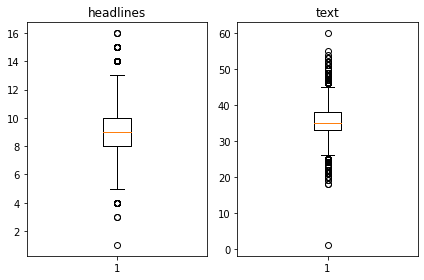

In [53]:
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))
print('헤드라인의 중앙값 : {}'.format(np.median(summary_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 중앙값 : {}'.format(np.median(text_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

헤드라인과 텍스트의 최대 길이를 정해주기 위해 boxplot으로 확인을 해주니, 평균과 중앙값도 거의 일치해서 아주 마음이 편안해지네요😊 최소 최대 값도 크게 차이 나지 않습니다.
- 헤드라인의 경우, 내용이 요약이 되어 있을테니 당연히 text보다 길이가 짧을 수밖에 없고 대부분 평균값 근처에 분포한다는 사실을 알 수 있습니다.
- 텍스트의 경우, 길이는 고루 분포해 있다는 사실을 알 수 있습니다. 자세한 건 아래 그래프로 다시 확인해보겠습니다.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


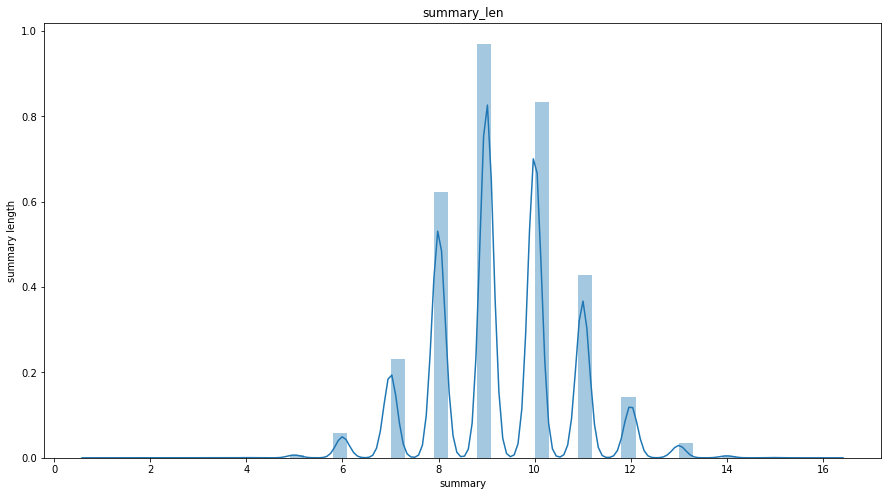

In [44]:
import seaborn as sns

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=summary_len, ax=ax)
plt.xlabel('summary')
plt.ylabel('summary length')
plt.title('summary_len')
plt.show()

헤드라인은 6에서 13 정도에 거의 분포해 있는 걸 확인할 수 있습니다. 크게 이상값이 없는 데이터인데 최대값을 어떻게 설정해주면 좋은 걸까요? 현재 데이터를 다 갖고 가는게 좋을까요?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


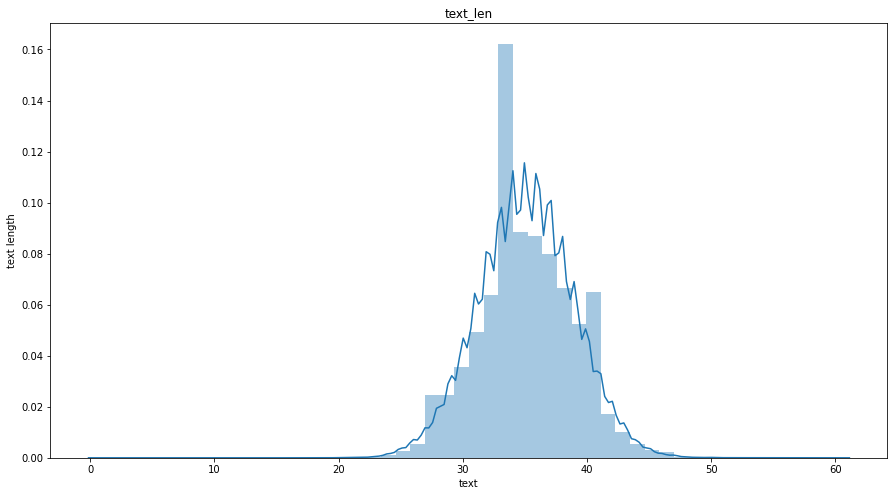

In [45]:
import seaborn as sns

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=text_len, ax=ax)
plt.xlabel('text')
plt.ylabel('text length')
plt.title('text_len')
plt.show()

텍스트는 평균이 35였던 점을 감안하면 30에서 많은 분포를 보여주고 있고, 50까지 서서히 줄어드는 모양입니다. 정규분포 모양과 사알짝 비슷하다 볼 수 있겠군요.

In [54]:
text_max_len = 40
summary_max_len = 10

샘플의 최대 길이를 정하는 과정에서 생각보다 많이 고민했습니다. 그냥 단순히 결정하고 넘어가도 되었을 문제인지, 잘 모르겠네요.   
- 저는 각각 40과 10으로 결정했습니다.

이 길이의 결정 근거는 boxplot의 Q3을 참고하여 결정하였습니다. 어쨌든 padding 값이 너무 많아지면 그렇게 좋은 벡터는 아닐테니까요🤣

이 길이는 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 됩니다. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단하겠습니다.

In [55]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [56]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92383627444994
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8166330829822311


막상 비율을 확인해보니 75% 정도는 아니었네요. 어쨌든 최댓값에 따라 텍스트는 8%, 헤드라인은 19% 정도를 Bye해야겠네요.👋

In [57]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74059


In [64]:
# 첫 데이터 크기
len_data = 98401


print('첫 데이터 크기와 비교한 현재 데이터 크기: %s'%((len(data)/len_data)*100))

첫 데이터 크기와 비교한 현재 데이터 크기: 75.26244651985245


## 시작 토큰과 종료 토큰 추가하기

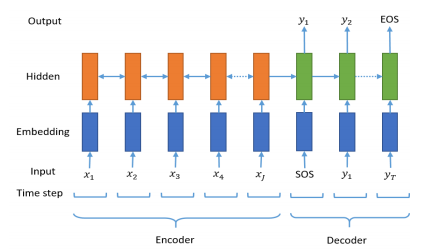

이미지 출처: [해당 논문](https://arxiv.org/pdf/1812.02303.pdf)

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 앞, 뒤로 추가하겠습니다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했습니다. 두 개의 문장 모두 headlines 열로부터 만들겠습니다.

In [65]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [66]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## train, test set 분리

In [67]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[35917 27828 30941 ... 36818 55768 39894]


In [70]:
# 정수 시퀀스를 통해 데이터의 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [72]:
# 이제 섞인 데이터를 8:2의 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14811


In [73]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59248
훈련 레이블의 개수 : 59248
테스트 데이터의 개수 : 14811
테스트 레이블의 개수 : 14811


각각 59,248개와 14,811개로 잘 분리되었습니다.

## 단어 사전(vocabulary) 만들기 및 정수 인코딩

In [74]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [75]:
src_tokenizer.word_index

{'said': 1,
 'year': 2,
 'india': 3,
 'added': 4,
 'us': 5,
 'also': 6,
 'police': 7,
 'government': 8,
 'people': 9,
 'first': 10,
 'two': 11,
 'indian': 12,
 'film': 13,
 'minister': 14,
 'old': 15,
 'crore': 16,
 'president': 17,
 'one': 18,
 'state': 19,
 'reportedly': 20,
 'court': 21,
 'world': 22,
 'years': 23,
 'new': 24,
 'reports': 25,
 'would': 26,
 'delhi': 27,
 'last': 28,
 'company': 29,
 'three': 30,
 'time': 31,
 'former': 32,
 'earlier': 33,
 'country': 34,
 'based': 35,
 'according': 36,
 'claimed': 37,
 'accused': 38,
 'man': 39,
 'like': 40,
 'congress': 41,
 'trump': 42,
 'bjp': 43,
 'million': 44,
 'day': 45,
 'allegedly': 46,
 'team': 47,
 'lakh': 48,
 'wednesday': 49,
 'comes': 50,
 'chief': 51,
 'singh': 52,
 'women': 53,
 'friday': 54,
 'tuesday': 55,
 'monday': 56,
 'pakistan': 57,
 'actor': 58,
 'made': 59,
 'around': 60,
 'woman': 61,
 'called': 62,
 'party': 63,
 'billion': 64,
 'thursday': 65,
 'pradesh': 66,
 'video': 67,
 'officials': 68,
 'found': 69,


In [76]:
len(src_tokenizer.word_index)

61565

총 61,565개의 단어에 index가 부여되었습니다. 와아 👏

In [85]:
src_tokenizer.word_counts.items()

odict_items([('karnataka', 1102), ('chief', 2862), ('minister', 5674), ('siddaramaiah', 161), ('monday', 2826), ('said', 31694), ('need', 726), ('make', 1738), ('agriculture', 116), ('profitable', 46), ('many', 1352), ('farmers', 554), ('giving', 435), ('farming', 35), ('due', 1979), ('severe', 149), ('crop', 62), ('loss', 579), ('among', 1340), ('others', 1316), ('speaking', 838), ('inauguration', 67), ('seed', 60), ('bhavan', 69), ('flower', 27), ('studio', 65), ('cm', 2069), ('also', 8350), ('directed', 1273), ('department', 1173), ('officials', 2508), ('take', 1914), ('action', 951), ('sellers', 53), ('spurious', 9), ('bad', 388), ('quality', 294), ('seeds', 29), ('telecom', 296), ('regulatory', 94), ('authority', 399), ('india', 10306), ('rolled', 130), ('new', 4327), ('website', 476), ('lets', 155), ('users', 2100), ('compare', 28), ('tariffs', 98), ('offered', 569), ('different', 733), ('service', 959), ('providers', 45), ('portal', 130), ('www', 8), ('tariff', 55), ('trai', 81)

src_tokenizer.word_counts.items()를 통해 단어 등장 빈도수를 살펴보겠습니다.
빈도가 7회 미만인 단어들이 얼마큼의 비중을 차지하는지 확인해 보겠습니다.

In [77]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61565
등장 빈도가 6번 이하인 희귀 단어의 수: 42273
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19292
단어 집합에서 희귀 단어의 비율: 68.66401364411597
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.191602735954606


등장 빈도가 7회 미만인 단어가 61,565 중 42,273개나 차지하며 68%의 비율을 차지하네요. 실제 훈련 데이터에서 단어 등장 빈도 비율은 약 4.2% 정도이니 상대적으로 적은 수치입니다.

그래서 등장 빈도가 7회 미만인 단어들은 정수 인코딩 과정에서 제외하여 훈련 데이터로 저장하기로 하겠습니다.

제외 시킬 경우 집합의 크기가 19,292개인데 단어 집합의 크기를 대략  19,000개로 제한해보겠습니다.

In [78]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

지금부터는 생성된 단어 집합에 기반하여 텍스트의 데이터를 모두 정수로 변환하는 정수 인코딩 과정을 texts_to_sequences() 와 함께 시행하겠습니다. 현재 단어 집합의 크기를 19,000로 제한해서 19,000이 넘는 숫자는 정수 인코딩 후 데이터에 존재하지 않습니다.

In [79]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[248, 51, 14, 2362, 56, 1, 462, 120, 3095, 6140, 180, 642, 856, 7374, 106, 2526, 5022, 604, 186, 195, 381, 4757, 5150, 4666, 8626, 4859, 97, 6, 209, 3095, 227, 68, 109, 315, 5573, 15900, 990, 1330, 8243], [1323, 3672, 960, 3, 56, 2819, 24, 771, 2438, 95, 8420, 1323, 3554, 614, 454, 313, 6238, 2820, 16861, 5457, 4133, 16862, 4909, 2074, 4133, 322, 59, 5457, 134, 865, 27, 6051, 727, 214, 4969, 24, 909], [5516, 2548, 85, 732, 9234, 5966, 663, 3584, 369, 1753, 2007, 7014, 45, 1599, 12, 1529, 2638, 785, 109, 315, 63, 267, 759, 525, 1589, 6, 1, 1443, 4178, 998, 5023, 694, 7638, 45, 167]]


#### headlines 데이터에도 동일한 작업 수행

In [80]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [81]:
tar_tokenizer.word_index

{'sostoken': 1,
 'to': 2,
 'in': 3,
 'for': 4,
 'of': 5,
 'on': 6,
 'with': 7,
 'india': 8,
 'after': 9,
 'from': 10,
 'at': 11,
 'over': 12,
 'us': 13,
 'by': 14,
 'not': 15,
 'as': 16,
 'the': 17,
 'is': 18,
 'man': 19,
 'govt': 20,
 'crore': 21,
 'delhi': 22,
 'world': 23,
 'be': 24,
 'trump': 25,
 'indian': 26,
 'up': 27,
 'report': 28,
 'pm': 29,
 'will': 30,
 'against': 31,
 'old': 32,
 'woman': 33,
 'year': 34,
 'bjp': 35,
 'new': 36,
 'first': 37,
 'was': 38,
 'cm': 39,
 'cr': 40,
 'mumbai': 41,
 'modi': 42,
 'reports': 43,
 'and': 44,
 'his': 45,
 'have': 46,
 'lakh': 47,
 'st': 48,
 'police': 49,
 'who': 50,
 'day': 51,
 'china': 52,
 'years': 53,
 'killed': 54,
 'no': 55,
 'minister': 56,
 'film': 57,
 'women': 58,
 'arrested': 59,
 'people': 60,
 'out': 61,
 'ex': 62,
 'its': 63,
 'case': 64,
 'gets': 65,
 'video': 66,
 'ceo': 67,
 'my': 68,
 'pak': 69,
 'sc': 70,
 'get': 71,
 'has': 72,
 'time': 73,
 'startup': 74,
 'found': 75,
 'into': 76,
 'pakistan': 77,
 'during': 78,

In [82]:
len(tar_tokenizer.word_index)

27281

In [84]:
tar_tokenizer.word_counts.items()

odict_items([('sostoken', 59248), ('need', 131), ('to', 16512), ('make', 420), ('agriculture', 8), ('profitable', 14), ('karnataka', 263), ('cm', 975), ('trai', 36), ('unveils', 149), ('new', 1093), ('website', 98), ('for', 9047), ('comparing', 8), ('telcos', 16), ('tariffs', 24), ('bajrang', 17), ('dal', 23), ('warns', 134), ('hyd', 43), ('pubs', 7), ('against', 1202), ('valentine', 19), ('day', 826), ('events', 30), ('decided', 12), ('act', 73), ('after', 3140), ('watching', 35), ('srk', 158), ('in', 15202), ('baazigar', 1), ('fukrey', 10), ('actor', 312), ('india', 3236), ('st', 853), ('transgender', 64), ('judge', 157), ('talks', 168), ('on', 6239), ('community', 32), ('troubles', 3), ('min', 109), ('goal', 94), ('helps', 96), ('chelsea', 46), ('beat', 141), ('arsenal', 34), ('thriller', 7), ('french', 194), ('tennis', 60), ('player', 371), ('smashes', 39), ('racquets', 2), ('one', 388), ('match', 315), ('smith', 114), ('test', 504), ('average', 34), ('goes', 177), ('down', 371), (

In [86]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27281
등장 빈도가 5번 이하인 희귀 단어의 수: 18268
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9013
단어 집합에서 희귀 단어의 비율: 66.96235475239178
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.000511529146004


이 데이터의 크기는 27,281이고 등장 빈도가 5번 이하인 단어의 수는 18268나 됩니다. 하지만 등장 빈도 비율로 따지면 약 6% 정도의 상대적으로 비슷하게 낮은 수치입니다. 이도 똑같은 과정을 거쳐 정수 인코딩 과정을 진행하겠습니다.

In [87]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 609, 3, 135, 6983, 4908, 252, 40], [1, 2417, 529, 37, 880, 5, 6984, 4474, 3313], [1, 4303, 3424, 596, 2042, 7527, 32, 3996, 52, 2792], [1, 5401, 3, 1231, 10, 2471, 494, 4, 6058, 202], [1, 9, 49, 1407, 498, 456, 7, 2668]]
target
decoder  [[609, 3, 135, 6983, 4908, 252, 40, 2], [2417, 529, 37, 880, 5, 6984, 4474, 3313, 2], [4303, 3424, 596, 2042, 7527, 32, 3996, 52, 2792, 2], [5401, 3, 1231, 10, 2471, 494, 4, 6058, 202, 2], [9, 49, 1407, 498, 456, 7, 2668, 2]]


#### 주의점❗

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 헤드라인(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 예정입니다.

In [88]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59248
훈련 레이블의 개수 : 59248
테스트 데이터의 개수 : 14810
테스트 레이블의 개수 : 14810


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했습니다. 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 합니다! 아까 정해두었던 최대 길이로 패딩 해주겠습니다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줍니다.

In [97]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계
### 함수형 API를 이용해서 인코더 설계

In [98]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로 정의
- hidden state의 크기를 256으로 정의

hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터입니다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해할 수 있습니다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아닙니다.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였습니다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있습니다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야합니다.

디코더를 설계해보겠습니다.

In [99]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일합니다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 합니다.

In [100]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2432000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

디코더의 출력층에서는 headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 합니다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있습니다.

디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 어텐션 메커니즘입니다.

# 3. 어텐션 메커니즘

In [101]:
# 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [102]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2432000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있습니다.

## 모델 훈련

In [103]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#val_loss(검증 데이터의 손실)을 관찰하다가, 
#검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 186s 741ms/step - loss: 6.6745 - val_loss: 5.8672
Epoch 2/50
232/232 [==============================] - 170s 732ms/step - loss: 5.8572 - val_loss: 5.5268
Epoch 3/50
232/232 [==============================] - 171s 738ms/step - loss: 5.4754 - val_loss: 5.2873
Epoch 4/50
232/232 [==============================] - 169s 729ms/step - loss: 5.1828 - val_loss: 5.0537
Epoch 5/50
232/232 [==============================] - 171s 735ms/step - loss: 4.9445 - val_loss: 4.9027
Epoch 6/50
232/232 [==============================] - 170s 735ms/step - loss: 4.7462 - val_loss: 4.7609
Epoch 7/50
232/232 [==============================] - 171s 738ms/step - loss: 4.5596 - val_loss: 4.6579
Epoch 8/50
232/232 [==============================] - 173s 746ms/step - loss: 4.3882 - val_loss: 4.5593
Epoch 9/50
232/232 [==============================] - 171s 738ms/step - loss: 4.2452 - val_loss: 4.4864
Epoch 10/50
232/232 [==============================] - 171s 737m

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있습니다. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있습니다.

[Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

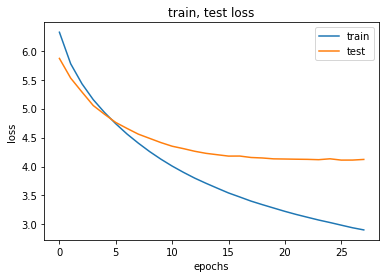

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train, test loss')
plt.show()

train, test set의 loss가 줄어드는 모습입니다.

# 인퍼런스 모델 구현
단어 사전 3개를 준비해둡니다.

In [106]:
src_index_to_word = src_tokenizer.index_word
# 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word
# 요약 단어 집합에서 정수 -> 단어를 얻음

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 합니다. 그걸 위해 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [107]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [108]:
# 어텐션 메커니즘을 사용하는 출력층을 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [109]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트

정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어야 합니다. 함수를 만들 때, text 의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고, summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만듭니다.

In [110]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [111]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : chinese man survived falling two metre long rod body groin shoulder fell getting struck lightning working construction site doctors performed seven hour surgery one said patient lucky rod damage vital organs 
실제 요약 : man gets by rod from to shoulder survives 
예측 요약 :  chinese man dies after falling into foot long child


원문 : india captain virat kohli featured highest paid sportsperson forbes india celebrity list crore earnings kohli retained third position overall youngest among top celebrities feature list indian shuttler pv sindhu placed th highest paid list crore earnings 
실제 요약 : kohli india top earning of at crore 
예측 요약 :  kohli becomes highest paid highest paid athletes


원문 : delhi gangrape victim nirbhaya mother asha devi monday said supreme court decision uphold death sentence convicts reaffirmed family trust court juveniles unfortunate committed crime added sc dismissed convicts petition reduce death sentence life term 
실제 요약 : this decision our trust in court nirbhaya

워드 임베딩과 lstm이 combibation 된 모델이 만든 요약본이네요! 

50개를 모두 꼼꼼히 보진 못했지만 실제 요약보다 괜찮아 보이는 것도 있어 보이고, 물론 이상한 요약도 섞여 있는 것 같습니다.

이 요약해주는 모델의 성능을 높이려면 어떻게 해야 할까요?

1. seq2seq와 어텐션 자체의 조합을 좀 더 좋게 수정하는 방법이 있습니다.
2. 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre.trained word embedding) 
3. 인코더-디코더 자체의 구조를 새로이 변경하는 트랜스포머(Transformer)

와 같은 여러 개선 방안들이 존재합니다.

# 4. 추출적 요약
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공합니다.

In [124]:
import requests
from summa.summarizer import summarize

In [125]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
original = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [126]:
print(original['text'][:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1495    India head coach Ravi Shastri has said that he...
1496    Italian tennis player Andreas Seppi ensured hi...
1497    World number three Roger Federer was stopped b...
1498    A cutout of TMC chief and West Bengal CM Mamat...
1499    A Delhi court on Saturday pulled up Delhi Poli...
Name: text, Length: 1500, dtype: object


## summarize 사용하기

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [131]:
print('Summary:')
print(summarize(original['text'][i], ratio=0.005))

Summary:



In [132]:
print('Summary:')
print(summarize(original['text'][i], ratio=0.05))

Summary:



In [133]:
print('Summary:')
print(summarize(original['text'][i], ratio=0.5))

Summary:
"It was a very emotional affair for everyone in my family," said Isha.


요약문으로 선택되는 문장의 개수를 줄여보기 위해 처음부터 ratio를 0.005%만 주고 출력해보았습니다. ratio가 0.5가 되었을 때 위와 비슷한 길이의 요약문이 나오네요. 다른 것도 조금 더 확인해 볼까요?

In [141]:
for i in range(15):
    print("원문 :", original['text'][i])
    print("실제 요약 :", original['headlines'][i])
    print("추출적 요약 :", summarize(original['text'][i], ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

# Extractive 요약과 Abstractive 요약의 비교

먼저 **Extractive 요약**의 첫 번째 예시를 살펴봅시다.

1. 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
2. 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
3. 예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.

전 추출적 요약보다 실제 요약이 더 좋은 요약으로 보여집니다. 추출적 요약은 원문에 나오는 문장을 그대로 인용하는 경우가 많았습니다. 왜냐하면 추출적 요약의 의미 자체가 원문에서 중욯란 핵심 문장 또는 단어구를 몇 개 뽑아서 구성된 요약문을 만드는 방식이기 때문입니다. 그래서 요약 문장을 보면 대부분 원문에 있는 문장임을 알 수 있을 것입니다.

글에서 때론 문장을 그대로 가져와서 요약하는 것이 합리적일 때도 있습니다. 하지만 그게 주제와 관련이 있지 않을 때도 있습니다. Summa는 MIT의 오픈 소스 소프트웨어라고 하는데요. 

1. 데이터 불러오기
2. 요약의 길이를 텍스트의 비율로 정의
3. 대략적인 단어 수로 요약의 길이 정의
4. 입력 텍스트 언어 정리
5. 결과 가져오기 

등의 명령을 소화합니다. 텍스트를 요약하기 위해 키워드를 추출하여 모델링을 하는 방식입니다. 그렇다면 원문에 없는 단어와 문장을 사용하면서 핵심을 뽑아냈던 것이 추출적 요약 앞에 했던 seq2seq을 사용한 **Abstractive 요약**입니다.

추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성하여 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식과 비슷합니다. 이 방법은 인공 신경망을 사용하여 대표적인 모델이 seq2seq가 있습니다. 단점은 지도 학습이라는 점입니다. 다시 말해 이 모델을 사용하기 위해서는 label이 있어야 합니다. headlines 같은 실제 요약이 있어야 한다는 점이죠. 그렇기 때문에 이 데이터를 구성하는 것 자체가 하나의 부담이 됩니다.

# 프로젝트 정리

### 소감
텍스트를 요약하는 Text Summarization 프로젝트는 매우 흥미로웠습니다. 구글 번역기와 함께 프로젝트를 하다보니, 프로젝트를 하며 말투가 점점 번역체가 되어 간 것 같습니다.😨 자연어 처리 파트는 생소하지만 계속 반복하다 보니 데이터 정제 과정까지의 flow에 점점 익숙해진 부분도 있습니다. 아직은 부족한 실력이지만요... 이번 과제를 하면서도 좋은 자료가 많다는 걸 느꼈고, 공부할 게 천지라는 걸 또 느꼈습니다.

### 프로젝트를 통해 배운 것

1. 텍스트 전처리
2. 텍스트에 패딩값을 넣어주는 정제 과정
3. 정수 인코딩, 인덱스에서 다시 텍스트로 등

여기까지는 nlp 프로젝트를 반복하며 복습할 수 있었던 부분이었고,

4. 단어 사전 크기를 줄이는 다양한 text normalization
    - 이 부분에서 고민을 많이 했던 것 같습니다. 다른 데이터로 따로 한 번 더 진행해보면 뭔가 감이 더 잡힐 것 같습니다.
4. 추출적 요약과 추상적 요약의 비교
5. 딥러닝 아키텍처 seq2seq
6. Attention Mechanism

등을 실습해 보았습니다.

#### 보충 학습(더 실습해보고 싶습니까?)
말만 해놓고 하지 않는(^^;) 저지만 오늘도 정리를 해봅니다.😊

- [아마존 리뷰 데이터](https://www.kaggle.com/snap/amazon-fine-food-reviews)
- [가이드](https://wikidocs.net/72820)